In [1]:
# !! sudo apt install -yq graphviz graphviz-dev
# !! python3 -m pip install -U --user pygraphviz transitions

In [2]:
import io
import random
import logging

from transitions.extensions import MachineFactory
Machine = MachineFactory.get_predefined(graph=True, nested=True)

from IPython.display import Image, display, display_png

In [3]:
logging.getLogger('transitions').setLevel(logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
_formatter = logging.Formatter(
    '%(asctime)s %(levelname)s - %(message)s')
_consolelog = logging.StreamHandler()
_consolelog.setLevel(logging.DEBUG)
_consolelog.setFormatter(_formatter)
logger.addHandler(_consolelog)

In [4]:
# import serial  # mocking


RFID_READER_PORT = '/dev/ttyUSB0'


class RFIDReader():
    '''Active Reader Passive Tag (ARPT) system:
    an active reader, which transmits interrogator signals
    and also receives authentication replies from passive tags. '''

    def __init__(self, port=RFID_READER_PORT, speed=9600, timeout=None):
        self.port = port
        self.speed = speed
        self.timeout = timeout
        self._disconnected_error = False
        self._misconfigured_error = False

    def read(self, nbytes=15):
        if self._disconnected_error:
            logger.critical('RFID_READER_DISCONNECTED_ERROR')
        if self._misconfigured_error:
            logger.critical('RFID_READER_MISCONFIGURED_ERROR')

        try:
            # with serial.Serial(
            #         self.port, self.speed, self, self.timeout) as reader:
            #     if nbytes and isinstance(nbytes, int):
            #         return reader.read(nbytes)
            #     else:
            #         return reader.read()
            # Mock
            # self._disconnected_error = bool(random.uniform(0, 1) > 0.98)
            #from uuid import uuid4

            #uid = uuid4()
            #return (RFIDTag.id_match_start + str(uid)[0:16] + RFIDTag.id_match_end 
            return (RFIDTag.id_match_start + '1234567890ABCDEF' + RFIDTag.id_match_end 
                    if not self._disconnected_error and not self._misconfigured_error else None)

        except serial.SerialException:
            # raise DisconnectedError
            self._disconnected_error = True
        except ValueError as e:
            # raise MisconfiguredError
            self._misconfigured_error = True
        
        


class RFIDTag:
    id_match_start = '$A0112OKD'
    id_match_end = '#'
    
    def validate(self, code: str) -> str:
        if len(code) >= 1:
            code = code.split(RFIDTag.id_match_start, 1)[1]
            code = code.split(RFIDTag.id_match_end, 1)[0]
            
            logger.info('RFIDReader: validated tag id: %s', code)
            self.id = code
            return self.id
        
        return False    


reader = RFIDReader()

In [5]:
class System:
    def __init__(self, reader, db):
        self.reader = reader
    
    def valid_tag(self, *args, **kwargs):
        logger.debug('valid_tag:%s: %s %s', self.state, args, kwargs)

        if current_tag is None or not current_tag.validate(*args, **kwargs):
            return False

        return True


    def invalid_tag(self, *args, **kwargs):
        global current_tag
        
        logger.debug('invalid_tag:%s: %s %s', self.state, args, kwargs)
        
        if current_tag is not None and current_tag.validate(*args, **kwargs):
            return False

        current_tag = None
        return True


    def reader_disconnected(self, *args, **kwargs):
        logger.debug('not_connected:%s: %s %s', self.state, args, kwargs)
        return True if self.reader._disconnected_error or self.reader._misconfigured_error else False
    
    def reader_read(self, *args, **kwargs):
        global current_tag
        
        logger.debug('on_tagreading_init:%s: %s %s', self.state, args, kwargs)

        current_tag = RFIDTag()
        current_tag.code = self.reader.read()
    
    def query_read(self, *args, **kwargs):
        global current_specimen
        
        try:
            session = dbinfos['session']      
            current_specimen = session.query(DB.Session)\
                                      .filter(DB.Session.ID_RFID == current_tag.id)\
                                      .first()
            logger.info('%s', specimen)

            if current_specimen is None or current_specimen.ID_Reneco is None:
                logger.warning('Bird Chip Not In Database')
                self.to_query_unknown('Bird Chip Not In Database')
            
            if current_specimen.Position is None:
                logger.warning('BIRD POSITION NOT IN DATABASE')
                self.to_query_unknown('BIRD POSITION NOT IN DATABASE')

            if current_specimen.Weight not in (None, 0, 0.0):
                logger.warning('Bird Already Weighed')
                self.to_query_unknown('Bird Already Weighed')

            #self.to_query_known()
        except Exception as e:
            logger.critical('DB related error: %s', e)
            self.to_query_unknown('DB related error: {}'.format(e))
    
    def acknowledgement(self):
        self.acknowledge()

    def show_graph(self, *args, **kwargs):
        stream = io.BytesIO()
        for terminal_node in [
                'tagreading_disconnected', 'tagreading_validated',
                'querying_known', 'querying_unknown',
                'weighing_rejected', 'weighing_validated',
                'updating_failed', 'updating_committed',
                'prompting_resolved']:
            self.get_graph(*args, **kwargs)\
               .get_node(terminal_node)\
               .attr.update(peripheries=2)

        self.get_graph(**kwargs)\
           .draw(stream, prog='dot', format='png')
        display(Image(stream.getvalue()))


import os, inspect, sys
imports = os.path.realpath(
    os.path.dirname(
        os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0])))
if imports not in sys.path:
    sys.path.insert(0, imports)

from datetime import datetime
import DB
# import Export
import settings
DB.initDB(''.join(['Prep_Weighing_test_', datetime.now().strftime('%Y%m%d'), '.db']), settings)
dbinfos = DB.testSession(settings)

system = System(reader, dbinfos['session'])
current_tag = None
current_specimen = None

2019-01-10 10:55:45,594 DEBUG - No module named 'spidev'
2019-01-10 10:55:45,595 WARNING - DB module: Assuming development environment, redirecting Screen functionality
2019-01-10 10:55:45,649 INFO - ** DATABASE UP TO DATE **
2019-01-10 10:55:45,649 INFO - ** DATABASE UP TO DATE **


db up to date


In [6]:
states = [
    'waiting', 
    'running', 
    {
        'name': 'tagreading', 
        'initial': 'init', 
        'children': ['init', 'read', 'disconnected', 'validated']
    }, {
        'name': 'prompting',
        'initial': 'init',
        'children': ['init', 'read', 'resolved']
    }, {
        'name': 'querying',
        'initial': 'init',
        'children': ['init', 'read', 'known', 'unknown']
    }, {
        'name': 'weighing',
        'initial': 'init',
        'children': ['init', 'read', 'rejected', 'validated']
    }, {
        'name': 'updating',
        'initial': 'init',
        'children': ['init', 'read', 'failed', 'committed']
    }
]

transitions = [
    ['run', 'waiting', 'running'],
    ['wait', ['running', 'prompting_resolved'], 'waiting'],
    # check database update, create .CSV
    ['collect_tag', 'running', 'tagreading'],
    ['collect_query', 'tagreading_validated', 'querying'],
    ['collect', 'querying_known', 'weighing'],  # valid chip and known specimen and known position and not already weighed today
    ['collect', 'weighing_validated', 'updating'],
    ['init_tag', ['tagreading'], 'tagreading_init'],
    ['init', ['querying', ], 'querying_init'],
    ['init', ['weighing', 'prompt_resolved'], 'weighing_init'],
    ['init', ['updating'], 'updating_init'],
    ['init', ['prompting', ], 'prompting_init'],
    {'trigger': 'read_tag', 'source': 'tagreading_init', 'dest': 'tagreading_read', 'after': system.reader_read},
    ['read_query', 'querying_init', 'querying_read'],
    ['read', 'weighing_init', 'weighing_read'],
    ['read', 'updating_init', 'updating_read'],
    ['read', 'prompting_init', 'prompting_read'],
    {'trigger': 'validate_tag', 'source': 'tagreading_read', 'dest': 'tagreading_validated', 'conditions': system.valid_tag, 'unless': system.reader_disconnected},
    {'trigger': 'validate_tag', 'source': 'tagreading_read', 'dest': 'tagreading_disconnected', 'after': system.acknowledgement},
    ['validate_tag', 'tagreading_read', 'tagreading_init', system.invalid_tag],
    {'trigger': 'validate_query', 'source': 'querying_read', 'dest': 'querying_unknown', 'after': system.acknowledgement},  # unregistered specimen or unknown specimen position
    ['validate_query', 'querying_read', 'querying_known'],  # registered specimen and known specimen position
    ['validate_query', 'querying_read', 'querying_init'],  # some db related error
    ['validate', 'weighing_read', 'weighing_validated'],  # normal specimen weight
    {'trigger': 'validate', 'source': 'weighing_read', 'dest': 'weighing_rejected', 'after': system.acknowledgement},  # inconsistent or pathological weight
    ['validate', 'weighing_read', 'weighing_init'],  # disconnected rfidreader 
    ['validate', 'updating_read', 'updating_committed'],  # database transaction committed
    {'trigger': 'validate', 'source': 'updating_read', 'dest': 'updating_failed', 'after': system.acknowledgement},  # db record update error
    ['validate', 'updating_read', 'updating_init'],
    ['validate', 'prompting_read', 'prompting_resolved'],  # confirmed pathological weight or reconnected rdfidreader or acknowledged (outdated db or specimen unknown position or unregistered specimen or specimen invalid rf chip id)
    ['acknowledge', ['tagreading_disconnected', 'querying_unknown', 'weighing_rejected', 'updating_failed', 'updating_committed'], 'prompting'],
    # collect operator's comments
]


In [7]:
machine = Machine(
    model=system,
    states=states, 
    transitions=transitions, 
    initial='waiting',
    show_auto_transitions=False,
    title="Master",
    show_conditions=True)

In [8]:
# system.show_graph()

In [9]:
system.run(), system.collect_tag()

2019-01-10 10:55:45,757 INFO - Exited state waiting
2019-01-10 10:55:45,757 INFO - Exited state waiting
2019-01-10 10:55:45,760 INFO - Entered state running
2019-01-10 10:55:45,760 INFO - Entered state running
2019-01-10 10:55:45,766 INFO - Exited state running
2019-01-10 10:55:45,766 INFO - Exited state running
2019-01-10 10:55:45,772 INFO - Entered state tagreading
2019-01-10 10:55:45,772 INFO - Entered state tagreading
2019-01-10 10:55:45,773 INFO - Entered state tagreading_init
2019-01-10 10:55:45,773 INFO - Entered state tagreading_init


(True, True)

In [10]:
system.read_tag()
current_tag, current_tag.code

2019-01-10 10:55:45,793 INFO - Exited state tagreading_init
2019-01-10 10:55:45,793 INFO - Exited state tagreading_init
2019-01-10 10:55:45,795 INFO - Entered state tagreading_read
2019-01-10 10:55:45,795 INFO - Entered state tagreading_read
2019-01-10 10:55:45,798 DEBUG - on_tagreading_init:tagreading_read: () {}
2019-01-10 10:55:45,798 DEBUG - on_tagreading_init:tagreading_read: () {}


(<__main__.RFIDTag at 0x7fec1a4edd68>, '$A0112OKD1234567890ABCDEF#')

In [11]:
system.validate_tag(current_tag.code), system.state

2019-01-10 10:55:45,815 DEBUG - valid_tag:tagreading_read: ('$A0112OKD1234567890ABCDEF#',) {}
2019-01-10 10:55:45,815 DEBUG - valid_tag:tagreading_read: ('$A0112OKD1234567890ABCDEF#',) {}
2019-01-10 10:55:45,818 INFO - RFIDReader: validated tag id: 1234567890ABCDEF
2019-01-10 10:55:45,818 INFO - RFIDReader: validated tag id: 1234567890ABCDEF
2019-01-10 10:55:45,820 DEBUG - not_connected:tagreading_read: ('$A0112OKD1234567890ABCDEF#',) {}
2019-01-10 10:55:45,820 DEBUG - not_connected:tagreading_read: ('$A0112OKD1234567890ABCDEF#',) {}
2019-01-10 10:55:45,825 INFO - Exited state tagreading_read
2019-01-10 10:55:45,825 INFO - Exited state tagreading_read
2019-01-10 10:55:45,832 INFO - Entered state tagreading_validated
2019-01-10 10:55:45,832 INFO - Entered state tagreading_validated


(True, 'tagreading_validated')

In [12]:
system.collect_query(), system.state

2019-01-10 10:55:45,846 INFO - Exited state tagreading_validated
2019-01-10 10:55:45,846 INFO - Exited state tagreading_validated
2019-01-10 10:55:45,849 INFO - Exited state tagreading
2019-01-10 10:55:45,849 INFO - Exited state tagreading
2019-01-10 10:55:45,854 INFO - Entered state querying
2019-01-10 10:55:45,854 INFO - Entered state querying
2019-01-10 10:55:45,857 INFO - Entered state querying_init
2019-01-10 10:55:45,857 INFO - Entered state querying_init


(True, 'querying_init')

In [13]:
system.read_query(), system.validate_query(), system.state

2019-01-10 10:55:45,874 INFO - Exited state querying_init
2019-01-10 10:55:45,874 INFO - Exited state querying_init
2019-01-10 10:55:45,880 INFO - Entered state querying_read
2019-01-10 10:55:45,880 INFO - Entered state querying_read
2019-01-10 10:55:45,887 INFO - Exited state querying_read
2019-01-10 10:55:45,887 INFO - Exited state querying_read
2019-01-10 10:55:45,893 INFO - Entered state querying_unknown
2019-01-10 10:55:45,893 INFO - Entered state querying_unknown
2019-01-10 10:55:45,899 INFO - Exited state querying_unknown
2019-01-10 10:55:45,899 INFO - Exited state querying_unknown
2019-01-10 10:55:45,901 INFO - Exited state querying
2019-01-10 10:55:45,901 INFO - Exited state querying
2019-01-10 10:55:45,903 INFO - Entered state prompting
2019-01-10 10:55:45,903 INFO - Entered state prompting
2019-01-10 10:55:45,905 INFO - Entered state prompting_init
2019-01-10 10:55:45,905 INFO - Entered state prompting_init


(True, True, 'prompting_init')

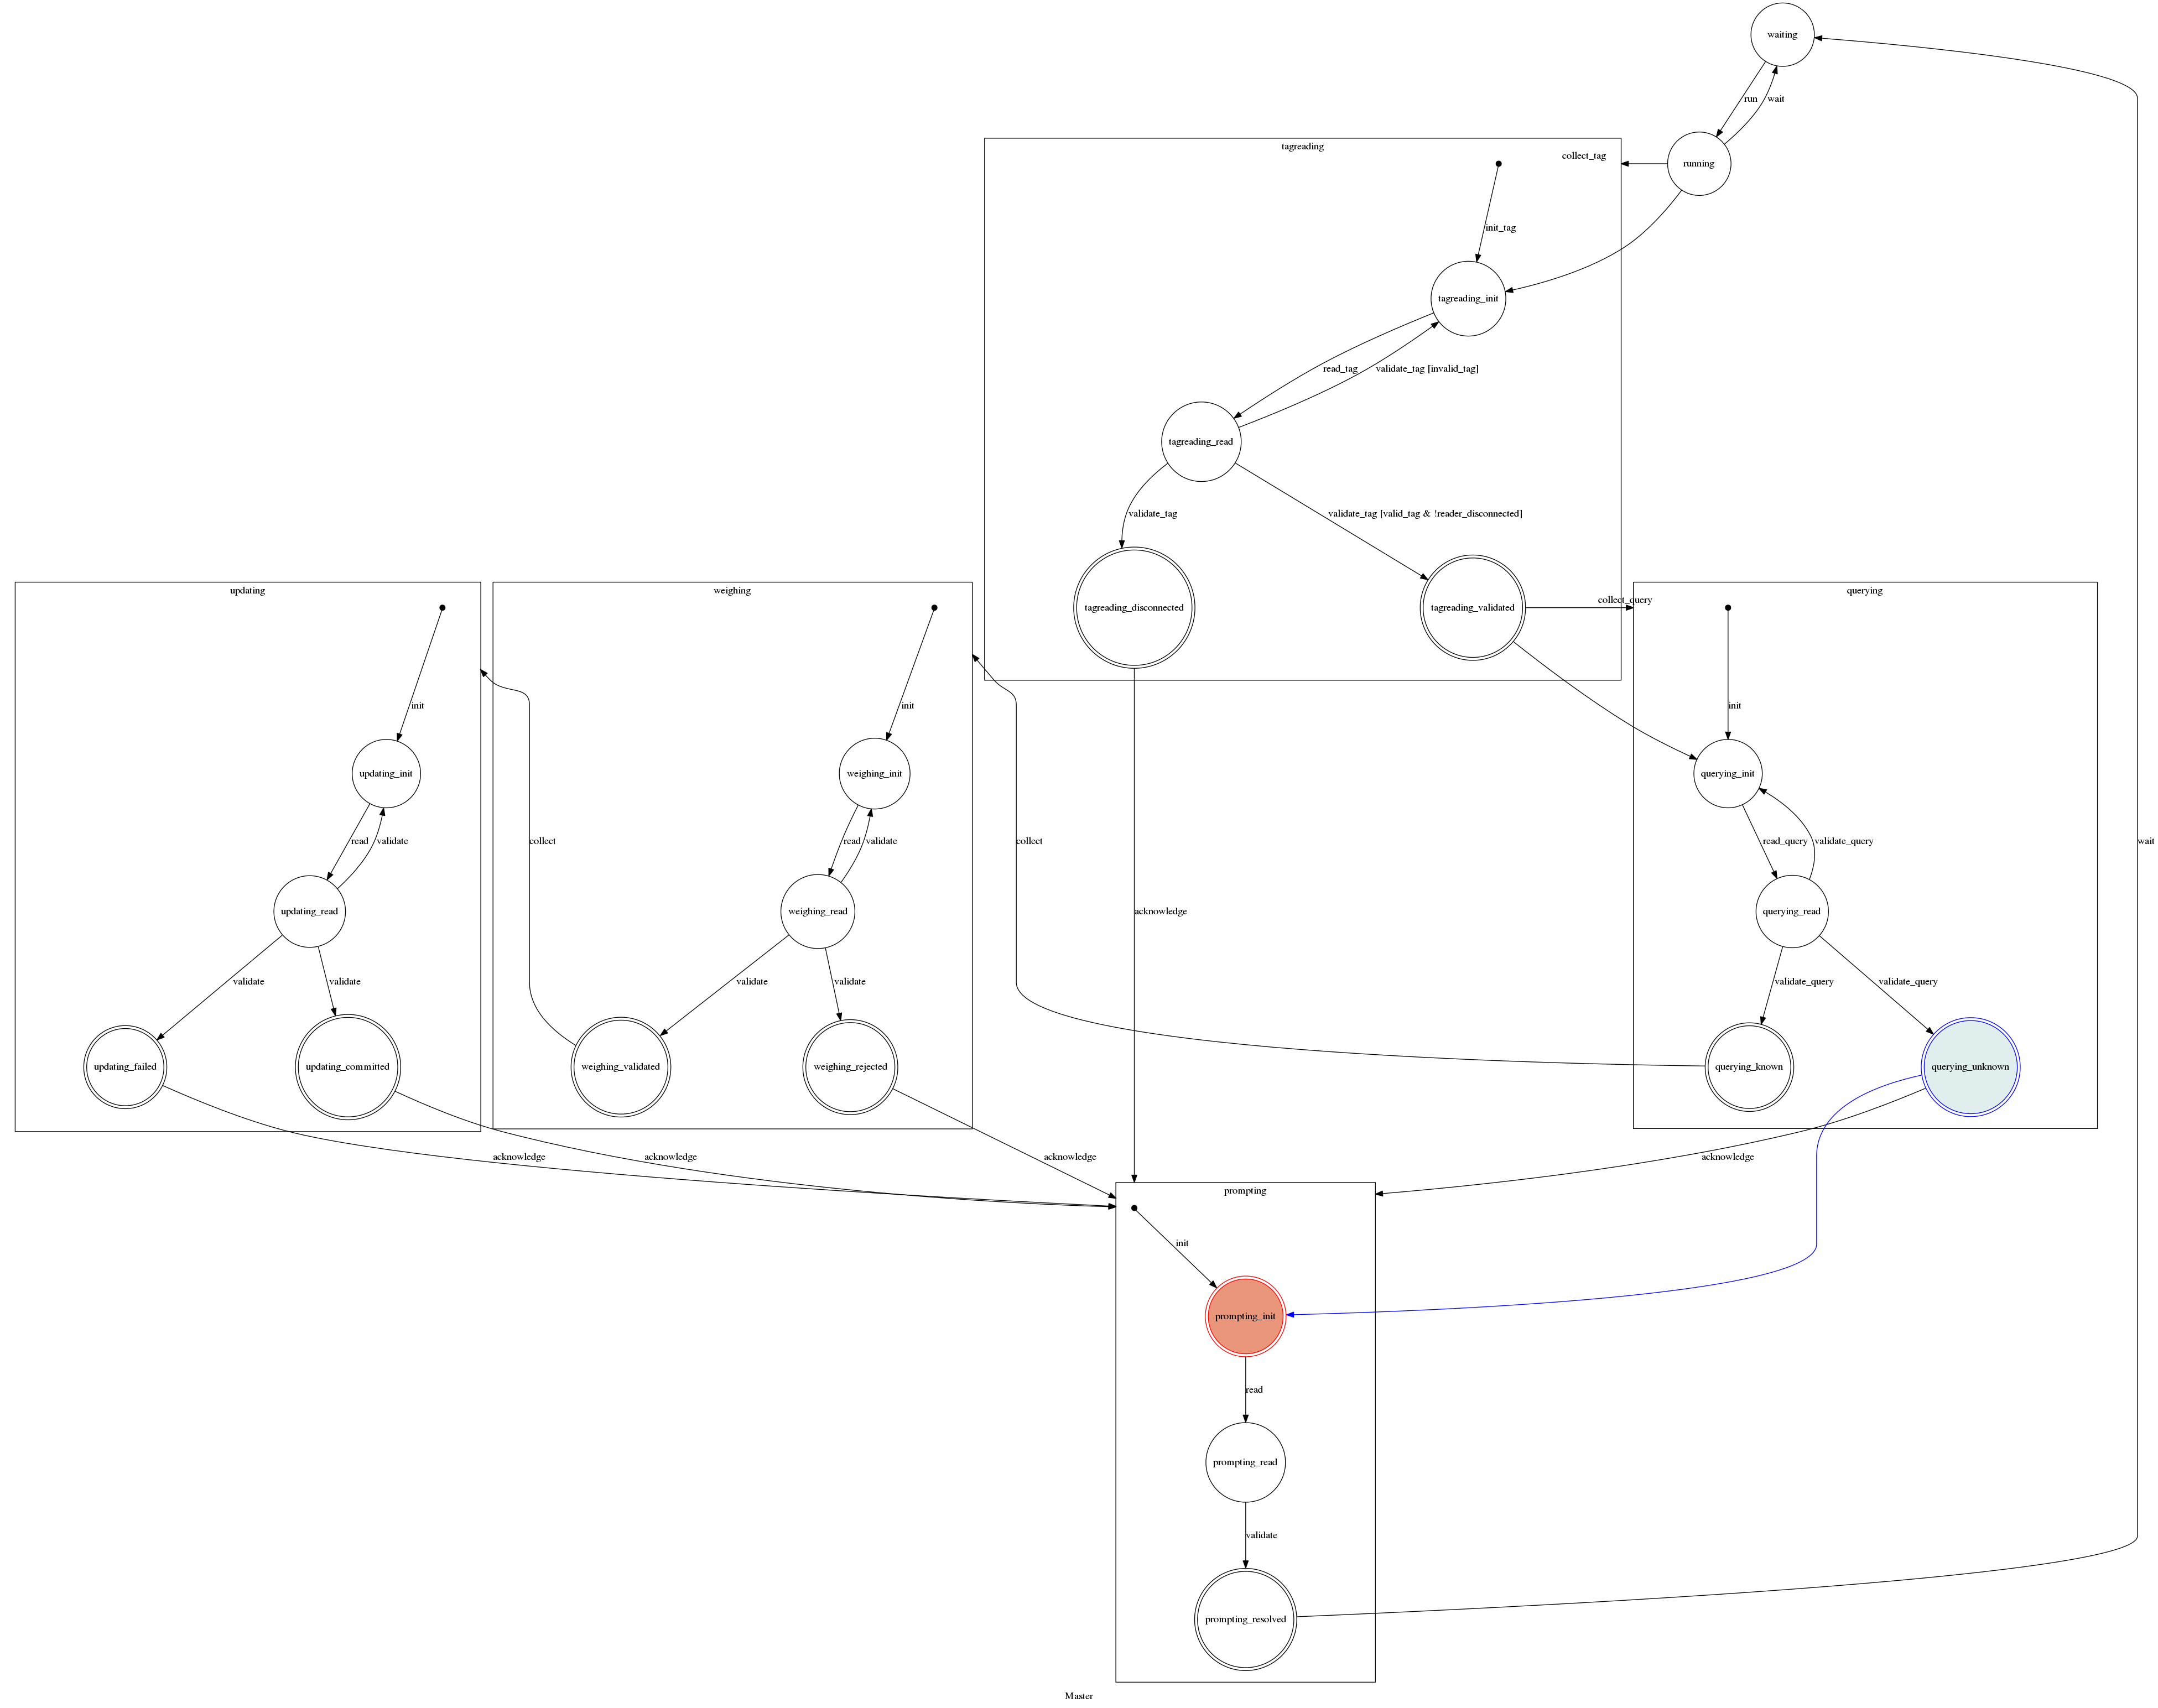

In [14]:
system.show_graph()